In [1]:
import numpy as np
import os, cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.utils import shuffle
from imutils import build_montages
from keras import backend as K
from keras.datasets import mnist
from keras.optimizers import Adam, RMSprop
from keras.models import Model, Sequential, load_model
from keras.layers import BatchNormalization, Input, LeakyReLU, GaussianNoise, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.core import Activation, Dense, Flatten, Reshape
from keras.utils import plot_model
from keras.initializers import RandomNormal
from keras.losses import BinaryCrossentropy, MeanSquaredError

# 1 - Implement VAE GAN

In [2]:
# Custom weight initialization function
def weights_init(shape, dtype=None):
    return tf.random.normal(shape, mean=0.0, stddev=0.02, dtype=dtype)

# Encoder Model
class Encoder(tf.keras.Model):
    def __init__(self):
        super(Encoder, self).__init__()
        self.conv1 = Conv2D(28, kernel_size=5, strides=2, padding='same', kernel_initializer=RandomNormal(stddev=0.02))
        self.bn1 = BatchNormalization(momentum=0.9)
        self.conv2 = Conv2D(128, kernel_size=5, strides=2, padding='same', kernel_initializer=RandomNormal(stddev=0.02))
        self.bn2 = BatchNormalization(momentum=0.9)
        self.conv3 = Conv2D(256, kernel_size=5, strides=2, padding='same', kernel_initializer=RandomNormal(stddev=0.02))
        self.bn3 = BatchNormalization(momentum=0.9)
        self.flatten = Flatten()
        self.fc1 = Dense(2048, kernel_initializer=RandomNormal(stddev=0.02))
        self.bn4 = BatchNormalization(momentum=0.9)
        self.fc_mean = Dense(64, kernel_initializer=RandomNormal(stddev=0.02))
        self.fc_logvar = Dense(64, kernel_initializer=RandomNormal(stddev=0.02))

    def call(self, x):
        x = LeakyReLU(0.2)(self.bn1(self.conv1(x)))
        x = LeakyReLU(0.2)(self.bn2(self.conv2(x)))
        x = LeakyReLU(0.2)(self.bn3(self.conv3(x)))
        x = self.flatten(x)
        x = LeakyReLU(0.2)(self.bn4(self.fc1(x)))
        mean = self.fc_mean(x)
        logvar = self.fc_logvar(x)
        return mean, logvar

# Decoder Model
class Decoder(tf.keras.Model):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc1 = Dense(7*7*256, kernel_initializer=RandomNormal(stddev=0.02))
        self.bn1 = BatchNormalization(momentum=0.9)
        self.reshape = Reshape((7, 7, 256))
        self.deconv1 = Conv2DTranspose(256, kernel_size=6, strides=2, padding='same', kernel_initializer=RandomNormal(stddev=0.02))
        self.bn2 = BatchNormalization(momentum=0.9)
        self.deconv2 = Conv2DTranspose(128, kernel_size=6, strides=2, padding='same', kernel_initializer=RandomNormal(stddev=0.02))
        self.bn3 = BatchNormalization(momentum=0.9)
        self.deconv3 = Conv2DTranspose(32, kernel_size=6, strides=1, padding='same', kernel_initializer=RandomNormal(stddev=0.02))
        self.bn4 = BatchNormalization(momentum=0.9)
        self.deconv4 = Conv2DTranspose(1, kernel_size=5, strides=1, padding='same', kernel_initializer=RandomNormal(stddev=0.02))
    
    def call(self, x):
        x = LeakyReLU(0.2)(self.bn1(self.fc1(x)))
        x = self.reshape(x)
        x = LeakyReLU(0.2)(self.bn2(self.deconv1(x)))
        x = LeakyReLU(0.2)(self.bn3(self.deconv2(x)))
        x = LeakyReLU(0.2)(self.bn4(self.deconv3(x)))
        x = tf.nn.tanh(self.deconv4(x))
        return x

# Discriminator Model
class Discriminator(tf.keras.Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = Conv2D(32, kernel_size=5, strides=1, padding='same', kernel_initializer=RandomNormal(stddev=0.02))
        self.relu = LeakyReLU(0.2)
        self.conv2 = Conv2D(128, kernel_size=5, strides=2, padding='same', kernel_initializer=RandomNormal(stddev=0.02))
        self.bn1 = BatchNormalization(momentum=0.9)
        self.conv3 = Conv2D(256, kernel_size=5, strides=2, padding='same', kernel_initializer=RandomNormal(stddev=0.02))
        self.bn2 = BatchNormalization(momentum=0.9)
        self.conv4 = Conv2D(256, kernel_size=5, strides=2, padding='same', kernel_initializer=RandomNormal(stddev=0.02))
        self.bn3 = BatchNormalization(momentum=0.9)
        self.flatten = Flatten()
        self.fc1 = Dense(512, kernel_initializer=RandomNormal(stddev=0.02))
        self.bn4 = BatchNormalization(momentum=0.9)
        self.fc2 = Dense(1, kernel_initializer=RandomNormal(stddev=0.02))
        self.sigmoid = tf.keras.activations.sigmoid

    def call(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.bn1(self.conv2(x)))
        x = self.relu(self.bn2(self.conv3(x)))
        x = self.relu(self.bn3(self.conv4(x)))
        x = self.flatten(x)
        x1 = x
        x = self.relu(self.bn4(self.fc1(x)))
        x = self.sigmoid(self.fc2(x))
        return x, x1

# VAE_GAN Model
class VAE_GAN(tf.keras.Model):
    def __init__(self):
        super(VAE_GAN, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
        self.discriminator = Discriminator()

    def call(self, x):
        z_mean, z_logvar = self.encoder(x)
        std = tf.math.exp(0.5 * z_logvar)
        epsilon = tf.random.normal(tf.shape(std))
        z = z_mean + std * epsilon
        x_tilda = self.decoder(z)
        return z_mean, z_logvar, x_tilda

# 2 - Training on MNIST

## 2.1 Configuration

In [3]:
timestamp = (datetime.now()).strftime("%y%m%d_%H%M%S")
output_path = os.path.join("output", 'VEAGAN_'+timestamp)
if not os.path.exists(output_path):
    os.makedirs(output_path)

In [4]:
OUTPUT = output_path
NUM_EPOCHS = 10 
BATCH_SIZE = 64 

## 2.2 Load MNIST

In [5]:
print("[INFO] loading MNIST dataset...")
((trainX, _), (testX, _)) = mnist.load_data()
trainImages = np.concatenate([trainX, testX])
trainImages = np.expand_dims(trainImages, axis=-1)
trainImages = (trainImages.astype("float") - 127.5) / 127.5
print(trainImages.shape)

[INFO] loading MNIST dataset...
(70000, 28, 28, 1)


## 2.3 - Initialize VEA-GAN

In [6]:
# Initialize models
gen = VAE_GAN()
discrim = Discriminator()

# Define optimizer and losses
lr = 3e-4
alpha = 0.1
gamma = 15
criterion = BinaryCrossentropy()
mse_loss = MeanSquaredError()
optim_E = RMSprop(learning_rate=lr)
optim_D = RMSprop(learning_rate=lr)
optim_Dis = RMSprop(learning_rate=lr * alpha)

# Define fixed noise and data for visualization
z_fixed = tf.random.normal(shape=(BATCH_SIZE, BATCH_SIZE))
x_fixed = trainImages[:BATCH_SIZE]

## 2.4 - Training

In [7]:
def plot_loss(loss_list):
    plt.figure(figsize=(10,5))
    plt.title("Loss During Training")
    plt.plot(loss_list,label="Loss")
    
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

In [9]:
for epoch in range(NUM_EPOCHS):
    batchesPerEpoch = int(trainImages.shape[0]/BATCH_SIZE)
    prior_loss_list, gan_loss_list, recon_loss_list = [], [], []
    dis_real_list, dis_fake_list, dis_prior_list = [], [], []

    for i in range(batchesPerEpoch):
        data = trainImages[i * BATCH_SIZE:(i+1) * BATCH_SIZE]
        bs = data.shape[0]

        ones_label = tf.ones((bs, 1))
        zeros_label = tf.zeros((bs, 1))
        zeros_label1 = tf.zeros((bs, 1))

        with tf.GradientTape(persistent=True) as tape:
            mean, logvar, rec_enc = gen(data)
            z_p = tf.random.normal((BATCH_SIZE, BATCH_SIZE))
            x_p_tilda = gen.decoder(z_p)

            output = discrim(data)[0]
            errD_real = criterion(output, ones_label)
            dis_real_list.append(errD_real.numpy())

            output = discrim(rec_enc)[0]
            errD_rec_enc = criterion(output, zeros_label)
            dis_fake_list.append(errD_rec_enc.numpy())

            output = discrim(x_p_tilda)[0]
            errD_rec_noise = criterion(output, zeros_label1)
            dis_prior_list.append(errD_rec_noise.numpy())

            gan_loss = errD_real + errD_rec_enc + errD_rec_noise
            gan_loss_list.append(gan_loss.numpy())

            output = discrim(data)[0]
            errD_real = criterion(output, ones_label)

            output = discrim(rec_enc)[0]
            errD_rec_enc = criterion(output, zeros_label)

            output = discrim(x_p_tilda)[0]
            errD_rec_noise = criterion(output, zeros_label1)

            gan_loss = errD_real + errD_rec_enc + errD_rec_noise

            x_l_tilda = discrim(rec_enc)[1]
            x_l = discrim(data)[1]

            rec_loss = tf.reduce_mean(tf.square(x_l_tilda - x_l))
            recon_loss_list.append(rec_loss.numpy())

            err_dec = gamma * rec_loss - gan_loss

            mean, logvar, rec_enc = gen(data)
            x_l_tilda = discrim(rec_enc)[1]
            x_l = discrim(data)[1]

            prior_loss = tf.reduce_mean(1 + logvar - tf.square(mean) - tf.exp(logvar))
            prior_loss = (-0.5 * tf.reduce_sum(prior_loss)) / tf.cast(tf.size(mean), dtype=tf.float32)

            prior_loss_list.append(prior_loss.numpy())
            err_enc = prior_loss + 5 * rec_loss

        gradients_E = tape.gradient(err_enc, gen.encoder.trainable_variables)
        gradients_D = tape.gradient(err_dec, gen.decoder.trainable_variables)
        gradients_Dis = tape.gradient(gan_loss, discrim.trainable_variables)

        optim_E.apply_gradients(zip(gradients_E, gen.encoder.trainable_variables))
        optim_D.apply_gradients(zip(gradients_D, gen.decoder.trainable_variables))
        optim_Dis.apply_gradients(zip(gradients_Dis, discrim.trainable_variables))

        if i % 50 == 0:
            print('[%d/%d][%04d/%d]\tLoss_gan: %.4f\tLoss_prior: %.4f\tRec_loss: %.4f\tdis_real_loss: %.4f\tdis_fake_loss: %.4f\tdis_prior_loss: %.4f'
                  % (epoch, NUM_EPOCHS, i, batchesPerEpoch,
                     np.mean(gan_loss_list), np.mean(prior_loss_list), np.mean(recon_loss_list),
                     np.mean(dis_real_list), np.mean(dis_fake_list), np.mean(dis_prior_list)))

    images = gen.decoder(z_fixed).numpy()
    images = ((images*127.5)+127.5).astype("uint8")
    images = np.repeat(images,3,axis=-1)
    vis = build_montages(images, (28,28), (8,8))[0]
    p = os.path.sep.join([OUTPUT, "epoch_{}_output.png".format(str(epoch+1).zfill(4))])
    cv2.imwrite(p, vis)


# plot_loss(prior_loss_list)
# plot_loss(recon_loss_list)
# plot_loss(gan_loss_list)

[0/10][0000/1093]	Loss_gan: 23.0350	Loss_prior: 0.0000	Rec_loss: 0.0002	dis_real_loss: 7.4257	dis_fake_loss: 7.8057	dis_prior_loss: 7.8036
[0/10][0050/1093]	Loss_gan: 21.4984	Loss_prior: 0.0004	Rec_loss: 0.0047	dis_real_loss: 5.3128	dis_fake_loss: 8.8255	dis_prior_loss: 7.3601
[0/10][0100/1093]	Loss_gan: 21.8598	Loss_prior: 0.0007	Rec_loss: 0.0035	dis_real_loss: 7.0737	dis_fake_loss: 7.8163	dis_prior_loss: 6.9697
[0/10][0150/1093]	Loss_gan: 20.7236	Loss_prior: 0.0046	Rec_loss: 0.0035	dis_real_loss: 9.0461	dis_fake_loss: 6.0896	dis_prior_loss: 5.5878
[0/10][0200/1093]	Loss_gan: 19.3926	Loss_prior: 0.0039	Rec_loss: 0.0031	dis_real_loss: 10.6101	dis_fake_loss: 4.5748	dis_prior_loss: 4.2078
[0/10][0250/1093]	Loss_gan: 18.5841	Loss_prior: 0.0033	Rec_loss: 0.0029	dis_real_loss: 11.5509	dis_fake_loss: 3.6635	dis_prior_loss: 3.3697
[0/10][0300/1093]	Loss_gan: 18.0441	Loss_prior: 0.0028	Rec_loss: 0.0027	dis_real_loss: 12.1792	dis_fake_loss: 3.0549	dis_prior_loss: 2.8100
[0/10][0350/1093]	Loss_g

AttributeError: 'numpy.ndarray' object has no attribute 'numpy'

Result after 1 epoch
(currently fail during running, i will revise code and update later)

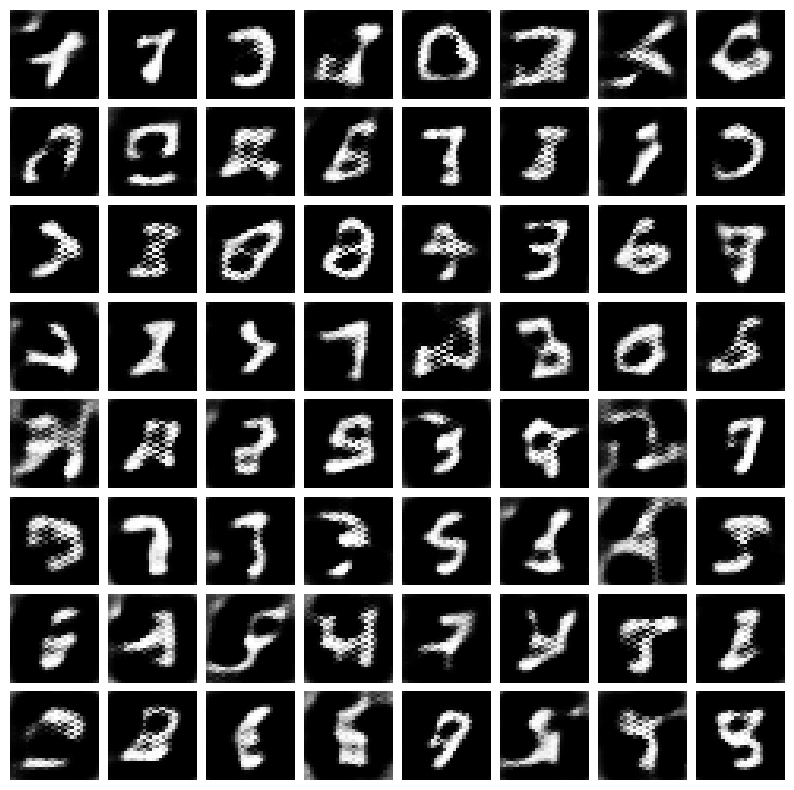

In [21]:
"""Plot a grid of images."""
images = gen.decoder(z_fixed).numpy()
fig, axes = plt.subplots(8, 8, figsize=(10, 10))
for i, ax in enumerate(axes.flatten()):
    img = images[i, :, :, 0]
    ax.imshow(img, cmap='gray')
    ax.axis('off')
plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()

In [ ]:
# # Example lists of losses (replace with your actual lists)
# epochs = range(1, len(disc_loss_list)+1)  # Assuming both lists have the same length

# # Plotting losses
# plt.figure(figsize=(10, 6))  # Adjust figure size as needed
# plt.plot(epochs, disc_loss_list, 'b', label='Disc Loss')
# plt.plot(epochs, gan_loss_list, 'r', label='Gan Loss')

# plt.title('Training Losses')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()

# plt.grid(True)
# plt.tight_layout()
# plt.show()


## 2.5 - Saving model

In [ ]:
# After training loop, save the generator and discriminator models
print("[INFO] saving models...")

# Define the paths to save the models
gen_model_path = os.path.join(OUTPUT, "vae_gan_weights.h5")
disc_model_path = os.path.join(OUTPUT, "discriminator_weights.h5")

gen.save_weights('gen_model_path.h5')
discrim.save_weights('disc_model_path.h5')

# 3 - Test on MNIST

In [ ]:
"""In case you just need to test the model without training:
- modify the OUTPUT param below to the directory of your trained model
- remember to run the first block which contains all libraries importing"""
# OUTPUT = ''

In [ ]:
# Load the saved models
gen_model_path = os.path.join(OUTPUT, "generator_model.h5")
disc_model_path = os.path.join(OUTPUT, "discriminator_model.h5")

gen_load = load_model(gen_model_path)
disc_load = load_model(disc_model_path)

# Function to generate an image and get discriminator prediction
def generate_and_predict(num_img):
    noise = np.random.uniform(-1, 1, (num_img, 100))
    
    # Generate images using the generator
    gen_images = gen_load.predict(noise, verbose=False)
    gen_images = ((gen_images * 127.5) + 127.5).astype("uint8")
    
    # Predict authenticity using the discriminator
    preds = disc.predict(gen_images.reshape(num_img, 28, 28, 1), verbose=False)
    
    # Calculate losses
    disc_loss = np.mean(preds)
    print(f"Average Discriminator loss: {disc_loss:.6f}")
    
    # Display the generated images and predictions
    plt.figure(figsize=(2*num_img, 2.5))
    for i in range(num_img):
        plt.subplot(1, num_img, i + 1)
        plt.imshow(gen_images[i].squeeze(), cmap='gray')
        plt.title(f"Disc: {preds[i][0]:.4f}")
        plt.axis('off')
    plt.show()

In [ ]:
generate_and_predict(10) #Randomly generate 10 image